# Behavioral Guided Single-Cell Transcriptomics Analysis (Part 2)
<span style="font-size:0.85em;">Written by: Farid Keramati (12 Feb 2024), Peter Brazda (12 Feb 2024) - Last Update: Farid Keramati (8 Mar 2024)</span>

## Different T Cell Subset Identification and Annotation 

&#10071;<b>Note:</b> Before runnig this analysis workflow, either make sure you have already run the previous part (part1) of the analysis workflow, or you have downloaded corresponding tables from Zenodo depository and have them in the current working directory.

 <div class="alert alert-block alert-warning">
&#9888;<b>Warning:</b> Based on different factors such as your operating system, R version, Seurat and other package versions the analysis results of different sections can be slightly different. However, major conclusions should not change.</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;If you want to reproduce downstream analysis exactly same, please use the provided Seurat objects in <a><b>Zenodo</b></a> depository.
</div>

This workflow aims to identify different T cell subsets in the dataset and annotate them. For this purpose, we will conduct a three step analysis workflow:
<details><summary><b>1. Read-in the data and remove low quality cells.</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.1. Load Required Libraries</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.2. Read in the pre-processed Seurat object</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.3. Remove Cycling Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.4. Generate a new Seurat object and remove low quality cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1.5. Normalize & Scale & Reduce dimentionality of the data</details>
<details><summary><b>2. Subset the dataset into two major T cell type (CD8 T and CD4 T) and perform standard single-cell analysis workflow for each subtype.</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1 Analyze CD8+ T cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.1 Generate Seurat Object and Embed Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.2 Batch Correction</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.1.3 Save Seurat Object for Downstream Analysis</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2 Analyze CD4+ T cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.1 Generate Seurat Object and Embed Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.2 Further Subset CD4+ T Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.3 Analyze CD4+/IL17RB- T Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.3.1 Generate Seurat Object and Embed Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.3.2 Batch Correction</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.3.3 Save Seurat Object for Downstream Analysis</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.4 Analyze CD4+/IL17RB+ T Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.4.1 Generate Seurat Object and Embed Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2.2.4.2 Save Seurat Object for Downstream Analysis</br>
</details>
<details><summary><b>3. Generate a Seurat Object of all T Cells.</b></summary>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.1 Generate the Object and Subset to Have Only Verified Cells</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.2 Normalize & Scale & Reduce dimentionality of the data</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.3 Batch Correction</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3.4 Save Seurat Object</br>
</details>

## 1. Read in the sequencing data and remove low quality cells

<div class="alert alert-info">
<b>Note:</b> It is important to subset the dataset into different T cell types as we aim to perform pseudotime analysis afterwards. </br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Biologically, it does not make sense to perform pseudotime on all different T cell subtypes at the same time.</div>

<details><summary>Before you start, make sure that you have the data in the current working directory.</summary>
    &nbsp;&nbsp;&nbsp;&nbsp;To set the working directory use the following code:</br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>setwd("path to the derised folder")</code></br>
    &nbsp;&nbsp;&nbsp;&nbsp;Otherwise you need to provide the path to the file you want to read in.
</details>

### 1.1 Load Required Libraries
<details><summary>For the following workflow we will need <code>Seurat</code>, <code>dplyr</code>, <code>ggplot2</code> and <code>SeuratWrappers</code> libraries.
Make sure you have them installed before starting the analysis.</summary>
&nbsp;&nbsp;&nbsp;&nbsp;Use the following code to install the required packages:</br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>install.packages(c("Seurat","dplyr","ggplot2","remotes"))</code></br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>remotes::install_github('satijalab/seurat-wrappers')</code></details>



In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(SeuratWrappers))

### 1.2 Read in the pre-processed ERCC-Removed Seurat object

In [2]:
plates = c('TM621', 'TM623', 'TM624', 'TM625', 'TM626', 'TM627', 'TM628', 'TM629', 
            'TM632', 'TM713', 'TM714', 'TM715', 'TM716', 'TM721', 'TM722')

# Grab the pre-processed plates, ERCC-genes are removed from the matrices
for (plate in plates) {
  file = paste(plate, "_noE.tab", sep = "") 
  plate_in = read.delim(paste("./2_noERCC/", file, sep = ""), header = TRUE, row.names = 1)
    assign(plate, CreateSeuratObject(counts = plate_in, min.cells = 2, min.features = 200))
}

Add Metada

In [3]:
TM621@meta.data$Engagement = "engager"; TM623@meta.data$Engagement = "nonengager"; TM624@meta.data$Engagement = "super-engaged"
TM625@meta.data$Engagement = "super-engaged"; TM626@meta.data$Engagement = "never-engaged"; TM627@meta.data$Engagement = "never-engaged"
TM628@meta.data$Engagement = "medium-exposed"; TM629@meta.data$Engagement = "medium-exposed"; TM632@meta.data$Engagement = "engager"
TM713@meta.data$Engagement = "super-engaged"; TM714@meta.data$Engagement = "super-engaged"; TM715@meta.data$Engagement = "never-engaged"
TM716@meta.data$Engagement = "never-engaged"; TM721@meta.data$Engagement = "medium-exposed"; TM722@meta.data$Engagement = "medium-exposed"

TM621@meta.data$Organoid = "13T"; TM623@meta.data$Organoid = "13T"; TM624@meta.data$Organoid = "13T"
TM625@meta.data$Organoid = "13T"; TM626@meta.data$Organoid = "13T"; TM627@meta.data$Organoid = "13T"
TM628@meta.data$Organoid = "none"; TM629@meta.data$Organoid = "none"; TM632@meta.data$Organoid = "13T"
TM713@meta.data$Organoid = "13T"; TM714@meta.data$Organoid = "13T"; TM715@meta.data$Organoid = "13T"
TM716@meta.data$Organoid = "13T"; TM721@meta.data$Organoid = "none"; TM722@meta.data$Organoid = "none"

TM621@meta.data$Plate = "TM621"; TM623@meta.data$Plate = "TM623"; TM624@meta.data$Plate = "TM624"
TM625@meta.data$Plate = "TM625"; TM626@meta.data$Plate = "TM626"; TM627@meta.data$Plate = "TM627"
TM628@meta.data$Plate = "TM628"; TM629@meta.data$Plate = "TM629"; TM632@meta.data$Plate = "TM632"
TM713@meta.data$Plate = "TM713"; TM714@meta.data$Plate = "TM714"; TM715@meta.data$Plate = "TM715"
TM716@meta.data$Plate = "TM716"; TM721@meta.data$Plate = "TM721"; TM722@meta.data$Plate = "TM722"

TM621@meta.data$Experiment = "series_2"; TM623@meta.data$Experiment = "series_2"; TM624@meta.data$Experiment = "series_2"
TM625@meta.data$Experiment = "series_2"; TM626@meta.data$Experiment = "series_2"; TM627@meta.data$Experiment = "series_2"
TM628@meta.data$Experiment = "series_2"; TM629@meta.data$Experiment = "series_2"; TM632@meta.data$Experiment = "series_2"
TM713@meta.data$Experiment = "series_3"; TM714@meta.data$Experiment = "series_3"; TM715@meta.data$Experiment = "series_3"
TM716@meta.data$Experiment = "series_3"; TM721@meta.data$Experiment = "series_3"; TM722@meta.data$Experiment = "series_3"

Merge data from different plates into a single Seurat object

In [4]:
teg_orig = suppressWarnings(merge(x=TM621, y=list(TM623,TM632,TM628, TM629,TM624,TM625,TM626,TM627,TM721,TM722,TM713, 
                                                      TM714,TM715,TM716)))

Normalize & Scale & Reduce dimentionality of the data</br>
For this step we utilized the <code><a>Guided Clustering Tutorial</a></code>workflow, suggested by the authors of <code>Seurat</code> package.

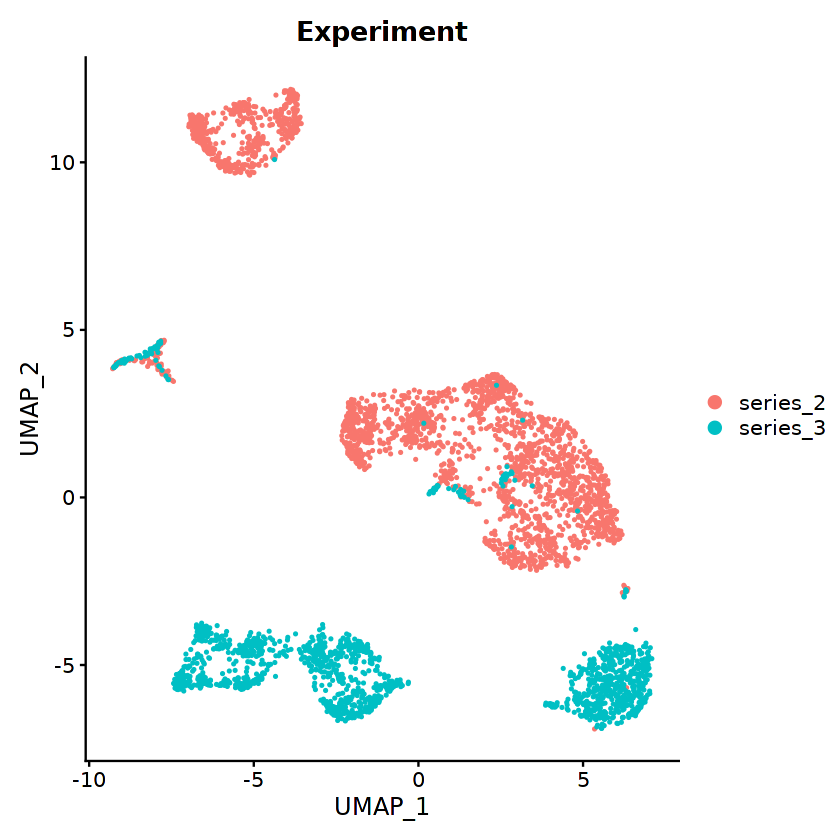

In [5]:
teg_orig = NormalizeData(teg_orig, verbose=F)%>% FindVariableFeatures(nfeatures = 4000, verbose=F) %>% ScaleData(features=rownames(teg_orig), verbose=F) %>% RunPCA(verbose=F)

teg_orig = suppressWarnings(RunUMAP(teg_orig, dims=1:30, min.dist=0.2, verbose=F)) %>% FindNeighbors(dims=1:30, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)

# Plot Cells
DimPlot(teg_orig, group.by="Experiment")

Batch correction to Remove Experimental Batch Effect

In [6]:
teg_orig = RunFastMNN(object.list=SplitObject(teg_orig, split.by="Experiment"), verbose=F)

teg_orig = RunUMAP(teg_orig, reduction = "mnn", dims = 1:30, verbose=F) %>% FindNeighbors(reduction="mnn", dims=1:30, verbose=F) %>% FindClusters(resolution=0.7, verbose=F)

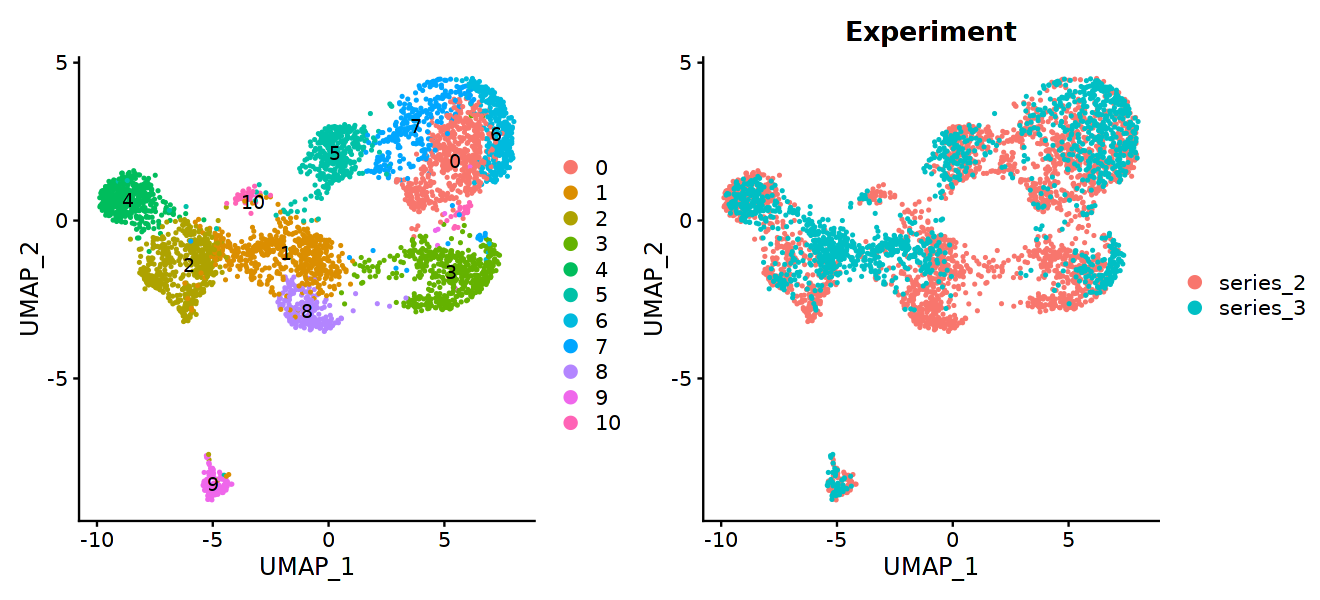

In [7]:
options(repr.plot.width=11, repr.plot.height=5)
DimPlot(teg_orig, label=T) + DimPlot(teg_orig, group.by = "Experiment")

### 1.3 Remove Cycling Cells
Using known markers (such as CENPA, TOP2A) we identified cycling (proliferating) cells and removed them from the dataset.

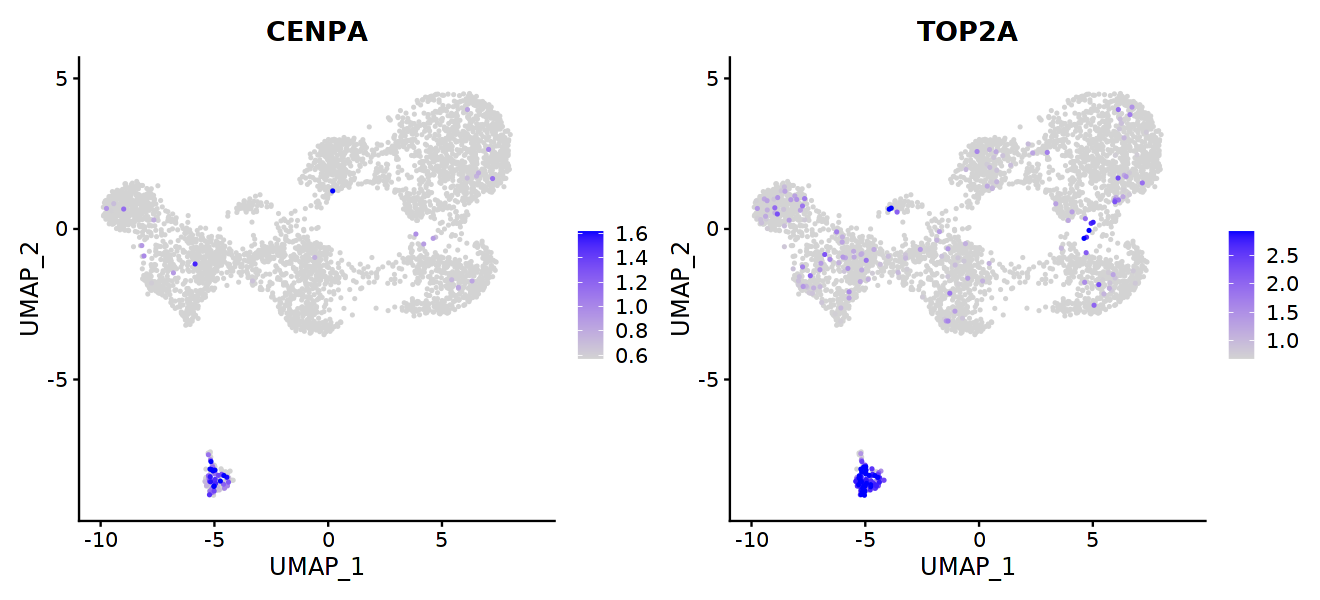

In [8]:
options(repr.plot.width=11, repr.plot.height=5)
FeaturePlot(teg_orig, order=T, max.cutoff = "q90", min.cutoff = "q10", c("CENPA","TOP2A")) # Cluster 9 is cycling cells.
teg_orig = subset(teg_orig, idents = "9", invert = T)

### 1.4 Generate a new Seurat object and remove low quality cells
After generating a new Seurat object we calculate the percentage of mitochondrial and ribosomal genes in each cell and remove cells with high percentage.</br>
Also, cells with exceedingly high or low amount of RNA and genes expressed were removed.

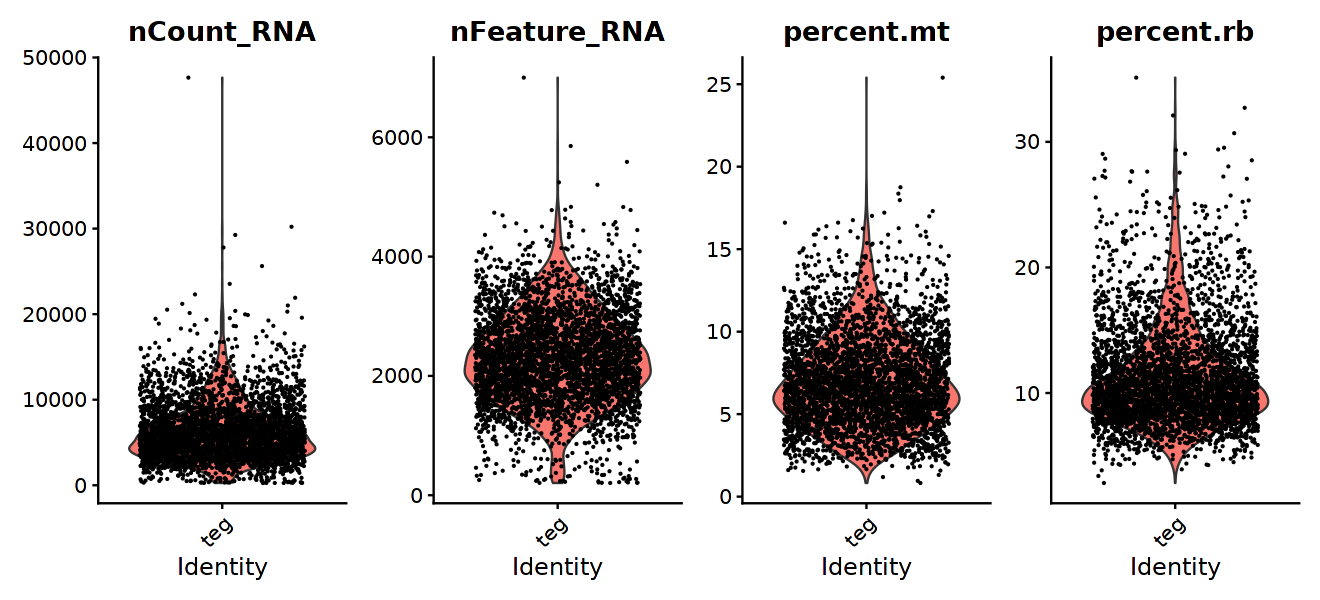

In [9]:
# Generate a new Seurat object
teg_counts = GetAssayData(teg_orig, slot = "counts")
teg = CreateSeuratObject(counts = teg_counts, project = "teg", min.cells = 6, min.features = 6)
teg$Engagement = teg_orig$Engagement
teg$Organoid = teg_orig$Organoid
teg$Experiment = teg_orig$Experiment
teg$Plate = teg_orig$Plate
teg[["percent.mt"]] = PercentageFeatureSet(teg, pattern = "MT-")
teg[["percent.rb"]] = PercentageFeatureSet(teg, pattern = "^RP[LS]")
VlnPlot(teg, features = c("nCount_RNA", "nFeature_RNA", "percent.mt", "percent.rb"), ncol = 4)

In [10]:
# Remove low quality cells
teg = subset(teg, subset = nFeature_RNA > 650 & nFeature_RNA < 4500 & nCount_RNA < 17500 & percent.mt < 15 & percent.rb < 30)

# Remove mito and rb genes (This step is optional, but will reduce the amount of noise during the downstream steps.)
mt.genes = rownames(teg)[grep("^MT-", rownames(teg))]
rb.genes = rownames(teg)[grep("^RP[LS]", rownames(teg))]
genes = c(mt.genes, rb.genes)
genes.keep = setdiff(rownames(teg), genes)
teg = subset(teg, features = genes.keep)
rm(genes, genes.keep, mt.genes, rb.genes)

### 1.5 Normalize & Scale & Reduce dimentionality of the data
For this step we utilized the <code><a>Guided Clustering Tutorial</a></code>workflow, suggested by the authors of <code>Seurat</code> package.

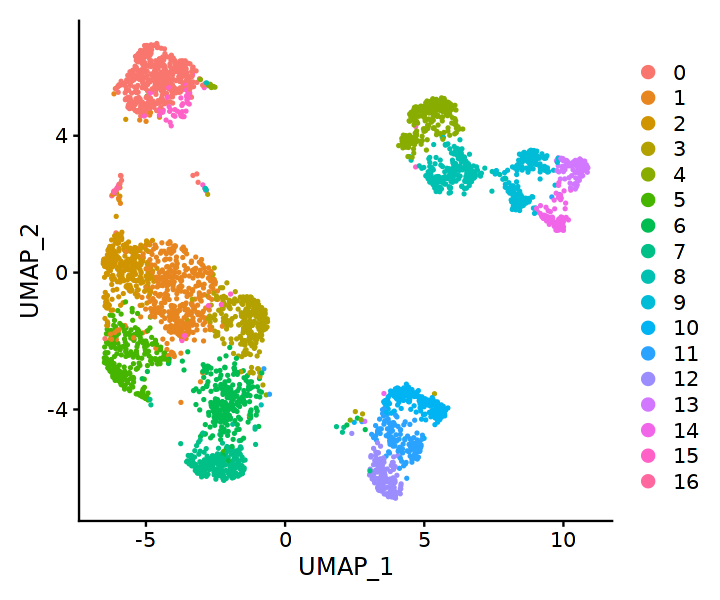

In [11]:
teg = NormalizeData(teg, verbose=F)%>% FindVariableFeatures(nfeatures = 3000, verbose=F) %>% ScaleData(features=rownames(teg), verbose=F) %>% RunPCA(verbose=F)

# UMAP embedding & Clusting
teg = suppressWarnings(RunUMAP(teg, dims=1:30, min.dist=0.2, verbose=F)) %>% FindNeighbors(dims=1:30, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)

# Plot Cells
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(teg)

## 2. Subset the dataset into two major T cell type (CD8 T and CD4 T)
Based on the expression levels of two marker genes (CD4 and CD8) we subset the dataset into two major T cell subsets.

In [12]:
pop1 = WhichCells(teg, expression = CD8A > CD4)
cd8_temp = subset(teg, cells = pop1)
cd8_temp$Engagement = teg$Engagement; cd8_temp$Organoid = teg$Organoid
cd8_temp$Experiment = teg$Experiment; cd8_temp$Plate = teg$Plate
cd4_temp = subset(teg, cells = pop1, invert = T)
cd4_temp$Engagement = teg$Engagement; cd4_temp$Organoid = teg$Organoid
cd4_temp$Experiment = teg$Experiment; cd4_temp$Plate = teg$Plate

### 2.1 Analyze CD8+ T cells
#### 2.1.1 Generate Seurat Object and Embed Cells
Just like before, we generate a new Seurat object of only CD8+ T cells and analyze them using the <code><a>Guided Clustering Tutorial</a></code> workflow.

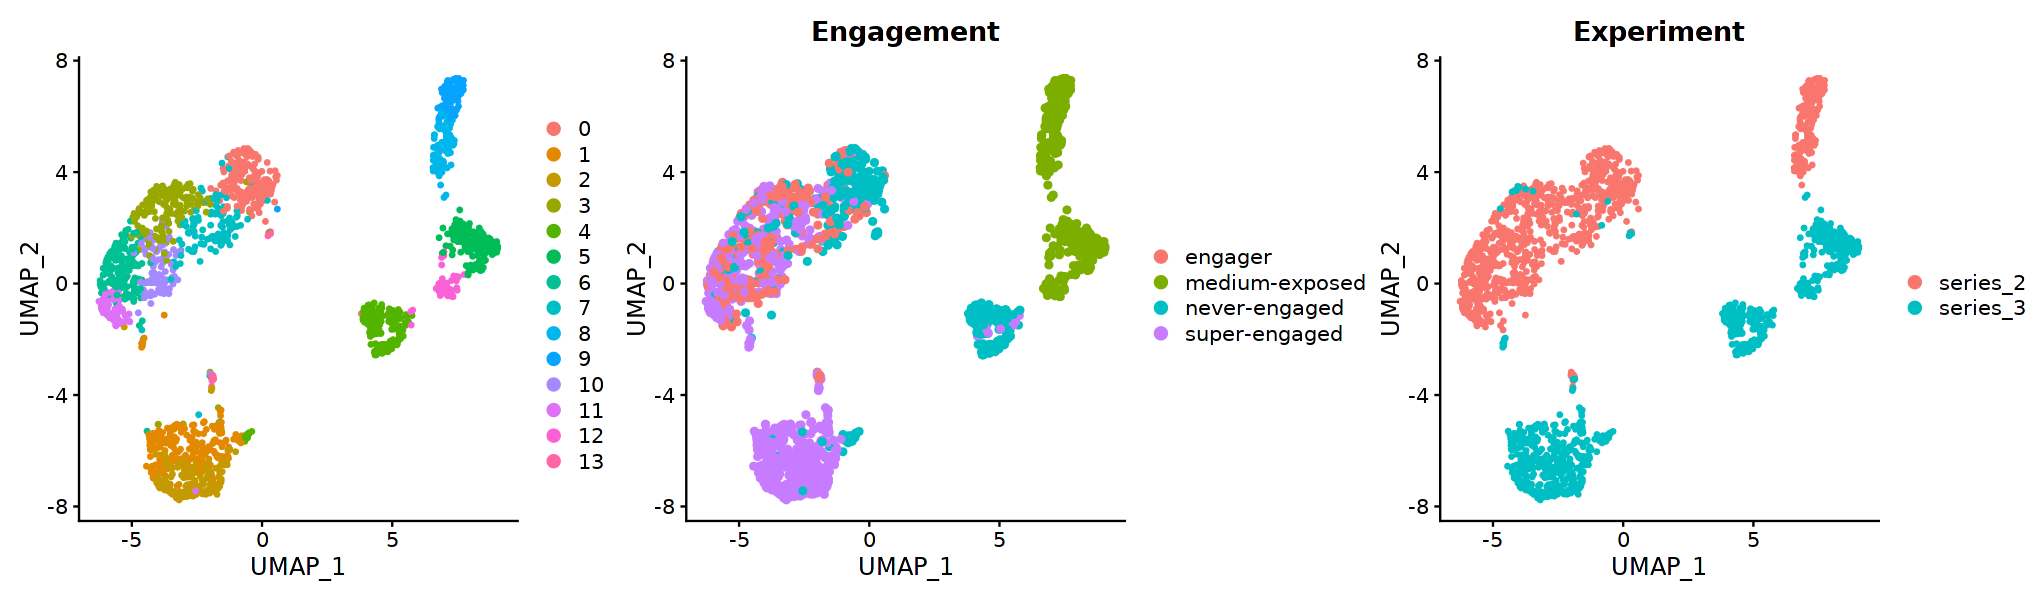

In [13]:
cd8_counts = GetAssayData(cd8_temp, slot="counts")
cd8 = CreateSeuratObject(counts=cd8_counts, project="cd8", min.cells=0, min.features=0)
cd8$Engagement = factor(cd8_temp$Engagement, levels = c("medium-exposed", "never-engaged", "nonengager", "engager", "super-engaged"))
cd8$Engagement = gsub("nonengager", "never-engaged", cd8$Engagement)
cd8$Organoid = cd8_temp$Organoid
cd8$Experiment = cd8_temp$Experiment
cd8$Plate = cd8_temp$Plate

# Normalized & Scale & PCA dimentionality reduction
cd8 = NormalizeData(cd8, verbose=F) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData(features=rownames(cd8), verbose=F) %>% RunPCA(verbose=F)

# UMAP embedding & Clusting
cd8 = RunUMAP(cd8, dims=1:12, min.dist=0.2, verbose=F) %>% FindNeighbors(dims=1:12, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)

# Plot
options(repr.plot.width=17, repr.plot.height=5)
DimPlot(cd8) + DimPlot(cd8, group.by="Engagement", pt.size=1.5, shuffle=T) + DimPlot(cd8, group.by="Experiment")

#### 2.1.2 Batch Correction
Based on the results of the previous section, there is a clear experimental batch effect that needs to be corrected.</br>
We will use <code>RunFastMNN</code> function from <code>SeuratWrappers</code> package, which is a fast implementation of the original <code>MNN</code> algorithm.

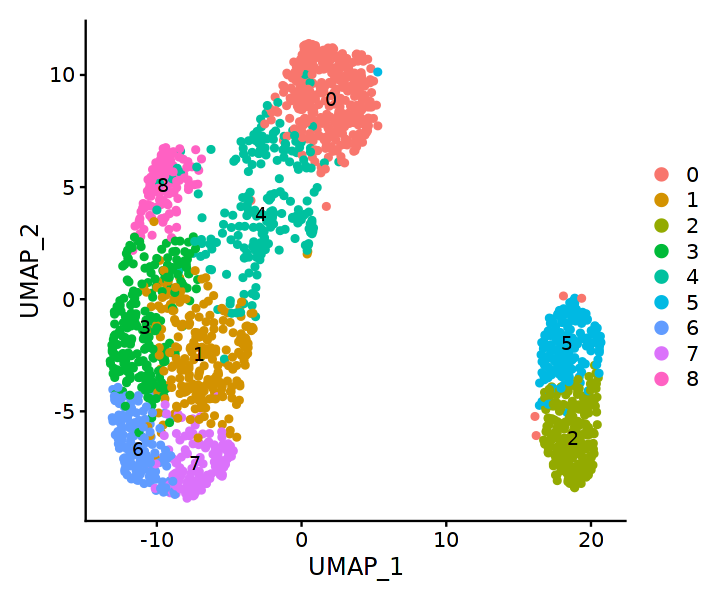

In [14]:
cd8_mnn = RunFastMNN(object.list=SplitObject(cd8, split.by="Experiment"), features=3000, verbose=F)

# UMAP embedding & Clusting
cd8_mnn = RunUMAP(cd8_mnn, dims=1:15, min.dist=0.3, spread=2.5, reduction="mnn", verbose=F) %>% FindNeighbors(dims=1:15, reduction="mnn", k.param=40, verbose=F) %>% FindClusters(resolution=1.5, verbose=F)
options(repr.plot.width=6, repr.plot.height=5)
DimPlot(cd8_mnn, label=TRUE, pt.size=1.5)

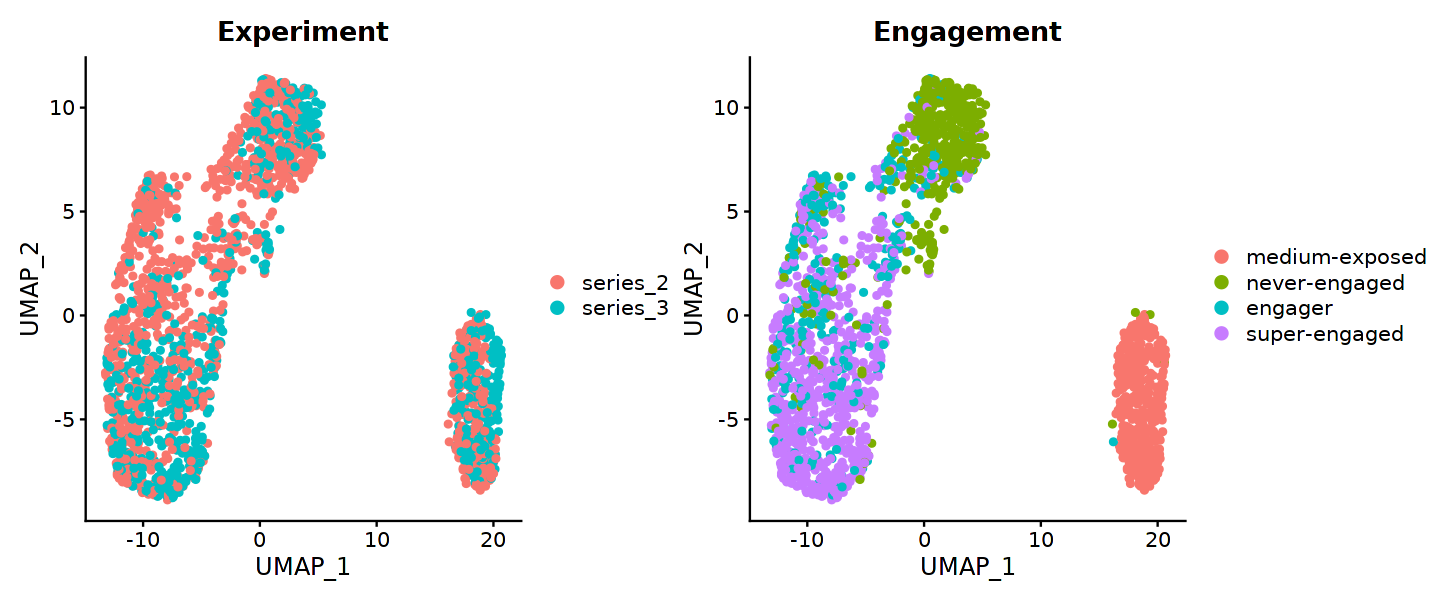

In [15]:
cd8_mnn$Engagement = factor(cd8_mnn$Engagement, levels=c("medium-exposed", "never-engaged", "engager", "super-engaged"))

# Plot Cells
options(repr.plot.width=12, repr.plot.height=5)
DimPlot(cd8_mnn, pt.size=1.5, shuffle=T, group.by="Experiment") + DimPlot(cd8_mnn, pt.size=1.5, group.by="Engagement", shuffle=T)

#### 2.1.3 Save Seurat Object for Downstream Analysis
From the above results, we have successfully corrected the batch effect and save the <code>cd8_mnn</code> object for downstream analysis.

In [16]:
saveRDS(cd8_mnn, "CD8_MNN_Seurat.rds")

</br>

### 2.2 Analyze CD4+ T cells
#### 2.2.1 Generate Seurat Object and Embed Cells
Just like before, we generate a new Seurat object of only CD4+ T cells and analyze them using the <code><a>Guided Clustering Tutorial</a></code> workflow.

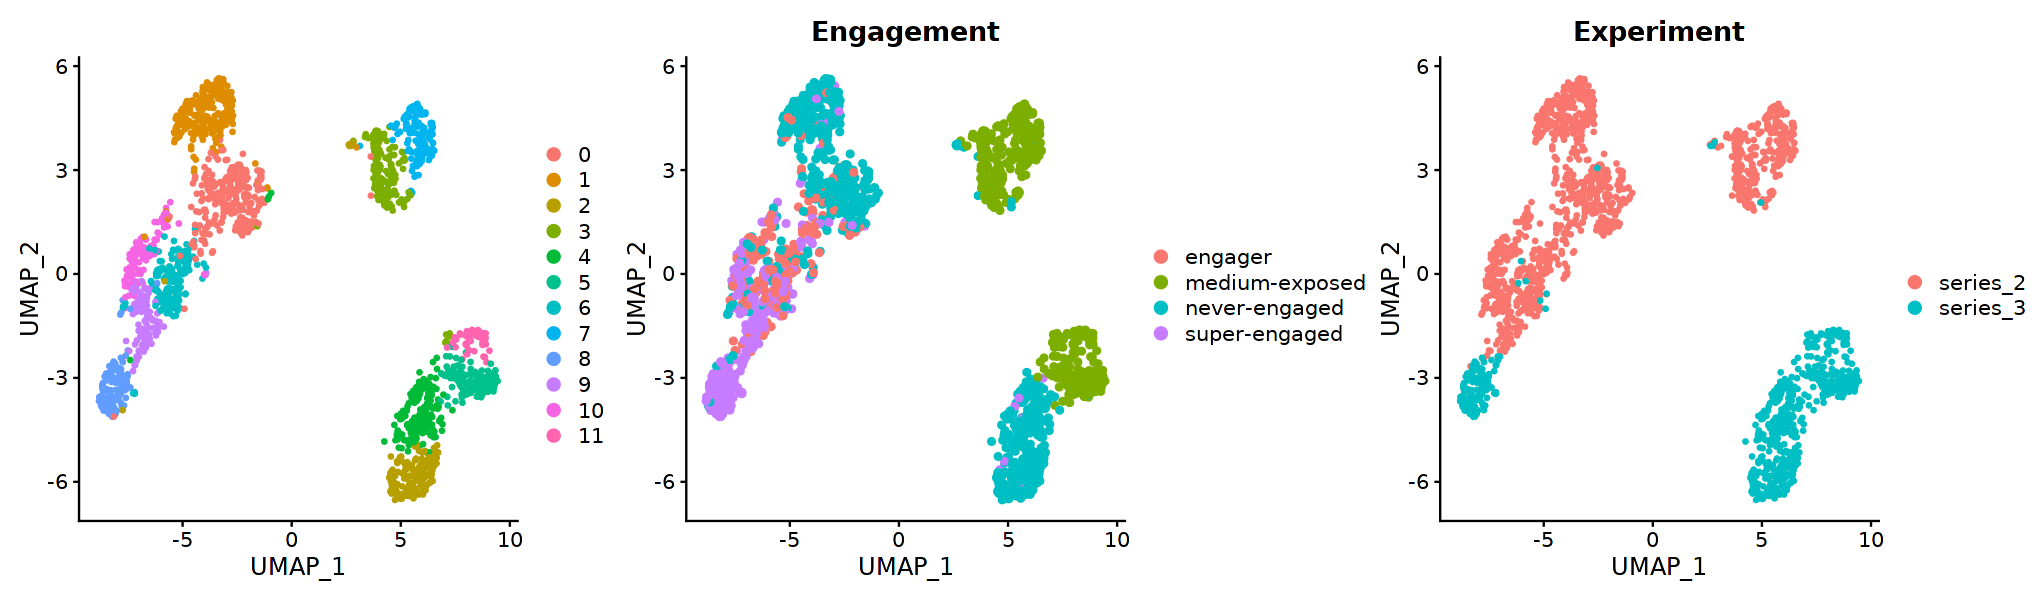

In [17]:
cd4_counts = GetAssayData(cd4_temp, slot="counts")
cd4 = CreateSeuratObject(counts=cd4_counts, project="cd4", min.cells=0, min.features=0)
cd4$Engagement = factor(cd4_temp$Engagement, levels=c("medium-exposed", "never-engaged", "nonengager", "engager", "super-engaged"))
cd4$Engagement = gsub("nonengager", "never-engaged", cd4$Engagement)
cd4$Organoid = cd4_temp$Organoid
cd4$Experiment = cd4_temp$Experiment
cd4$Plate = cd4_temp$Plate

# Normalized & Scale & PCA dimentionality reduction
cd4 = NormalizeData(cd4, verbose=F) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData(features=rownames(cd8), verbose=F) %>% RunPCA(verbose=F)

# UMAP embedding & Clusting
cd4 = RunUMAP(cd4, dims=1:12, min.dist=0.2, verbose=F) %>% FindNeighbors(dims=1:12, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)

# Plot
options(repr.plot.width=17, repr.plot.height=5)
DimPlot(cd4) + DimPlot(cd4, group.by="Engagement", pt.size=1.5, shuffle=T) + DimPlot(cd4, group.by="Experiment")

</br>

#### 2.2.2 Further Subset CD4+ T Cells
It appears that there are two subtuypes of T cells, best distinguished by "IL17RB".

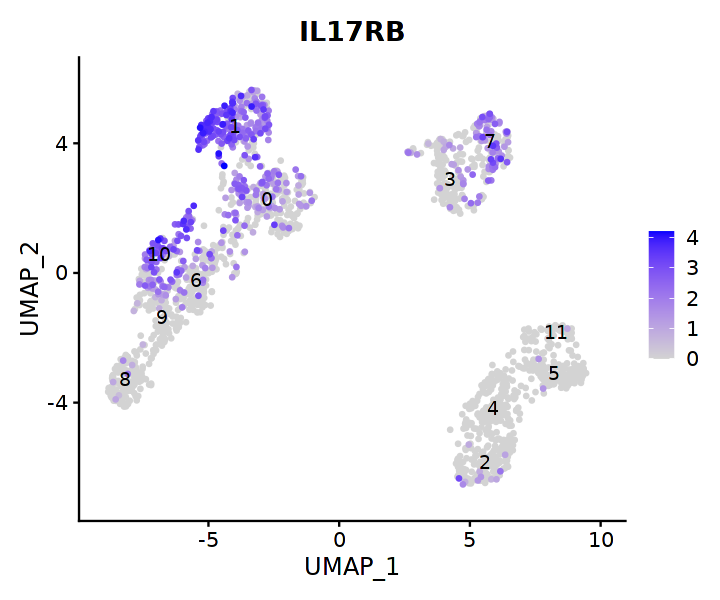

In [18]:
options(repr.plot.width=6, repr.plot.height=5)
FeaturePlot(cd4, order=T, "IL17RB", label=T)

So, we will further subset CD4+ T cells into two distinctive IL17RB+ and IL17RB- subsets.

In [19]:
cd4_temp_1 = subset(cd4, idents = c(1, 7, 10))
cd4_temp_1$Engagement = cd4$Engagement; cd4_temp_1$Organoid = cd4$Organoid
cd4_temp_1$Experiment = cd4$Experiment; cd4_temp_1$Plate = cd4$Plate
cd4_temp_2 = subset(cd4, idents = c(1, 7, 10), invert = T)
cd4_temp_2$Engagement = cd4$Engagement; cd4_temp_2$Organoid = cd4$Organoid
cd4_temp_2$Experiment = cd4$Experiment; cd4_temp_2$Plate = cd4$Plate

</br>

#### 2.2.3 Analyze CD4+/IL17RB- T Cells
#### 2.2.3.1 Generate Seurat Object and Embed Cells
Just like before, we generate a new Seurat object of only CD4+ IL17RB- T cells and analyze them using the <code><a>Guided Clustering Tutorial</a></code> workflow.

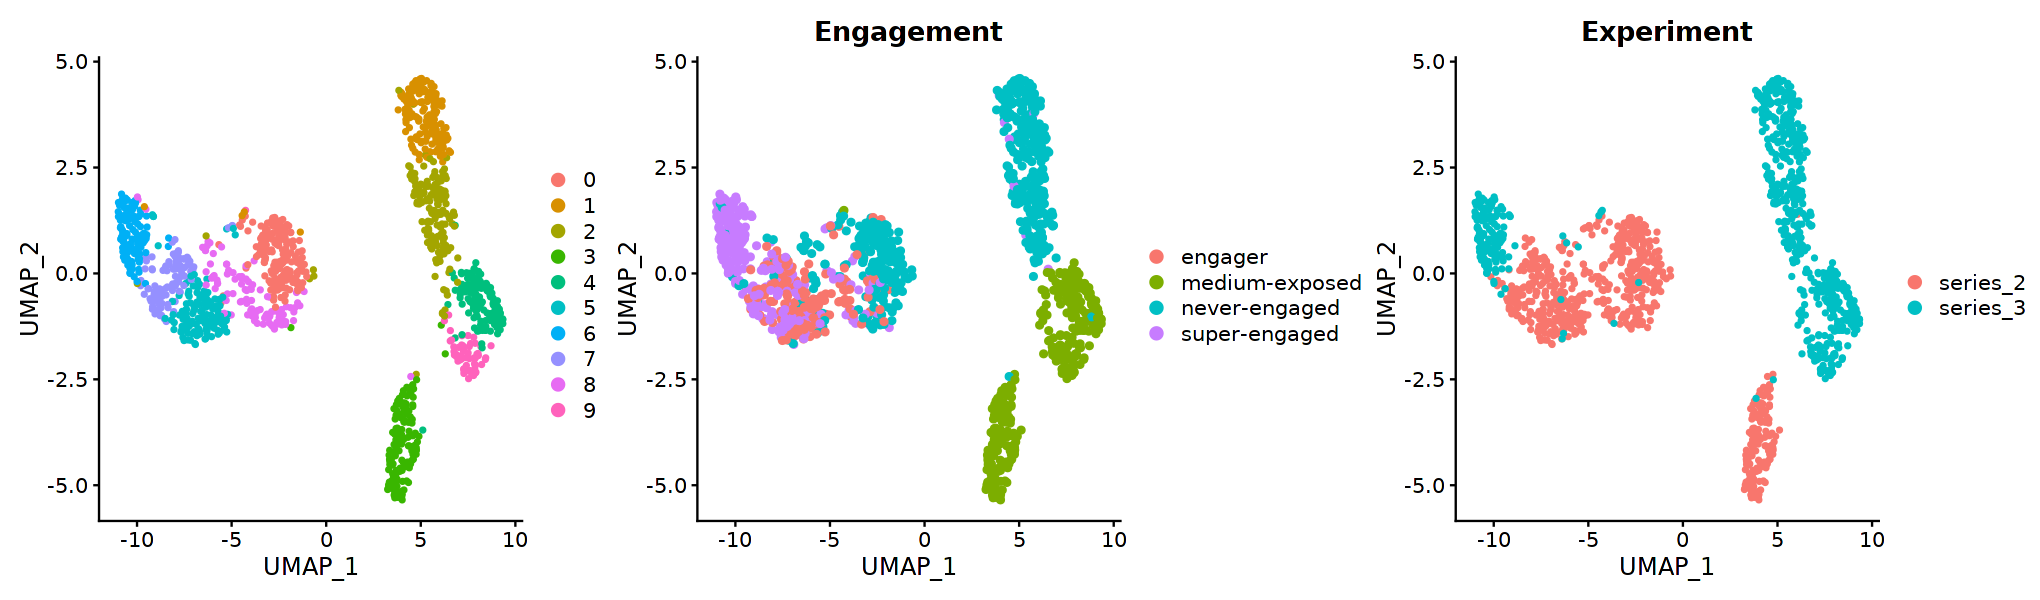

In [20]:
cd4_counts = GetAssayData(cd4_temp_2, slot = "counts")
cd4_2 = CreateSeuratObject(counts = cd4_counts, project = "cd4", min.cells = 0, min.features = 0)
cd4_2$Engagement = factor(cd4_temp_2$Engagement, levels = c("medium-exposed", "never-engaged", "nonengager", "engager", "super-engaged"))
cd4_2$Engagement = gsub("nonengager", "never-engaged", cd4_2$Engagement)
cd4_2$Organoid = cd4_temp_2$Organoid
cd4_2$Experiment = cd4_temp_2$Experiment
cd4_2$Plate = cd4_temp_2$Plate

# Normalized & Scale & PCA dimentionality reduction
cd4_2 = NormalizeData(cd4_2, verbose=F) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData(features=rownames(cd8), verbose=F) %>% RunPCA(verbose=F)

# UMAP embedding & Clusting
cd4_2 = RunUMAP(cd4_2, dims=1:12, min.dist=0.2, verbose=F) %>% FindNeighbors(dims=1:12, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)

# Plot
options(repr.plot.width=17, repr.plot.height=5)
DimPlot(cd4_2) + DimPlot(cd4_2, group.by="Engagement", pt.size=1.5, shuffle=T) + DimPlot(cd4_2, group.by="Experiment")

#### 2.2.3.2 Batch Correction
Based on the results of the previous section, there is a clear experimental batch effect that needs to be corrected.</br>

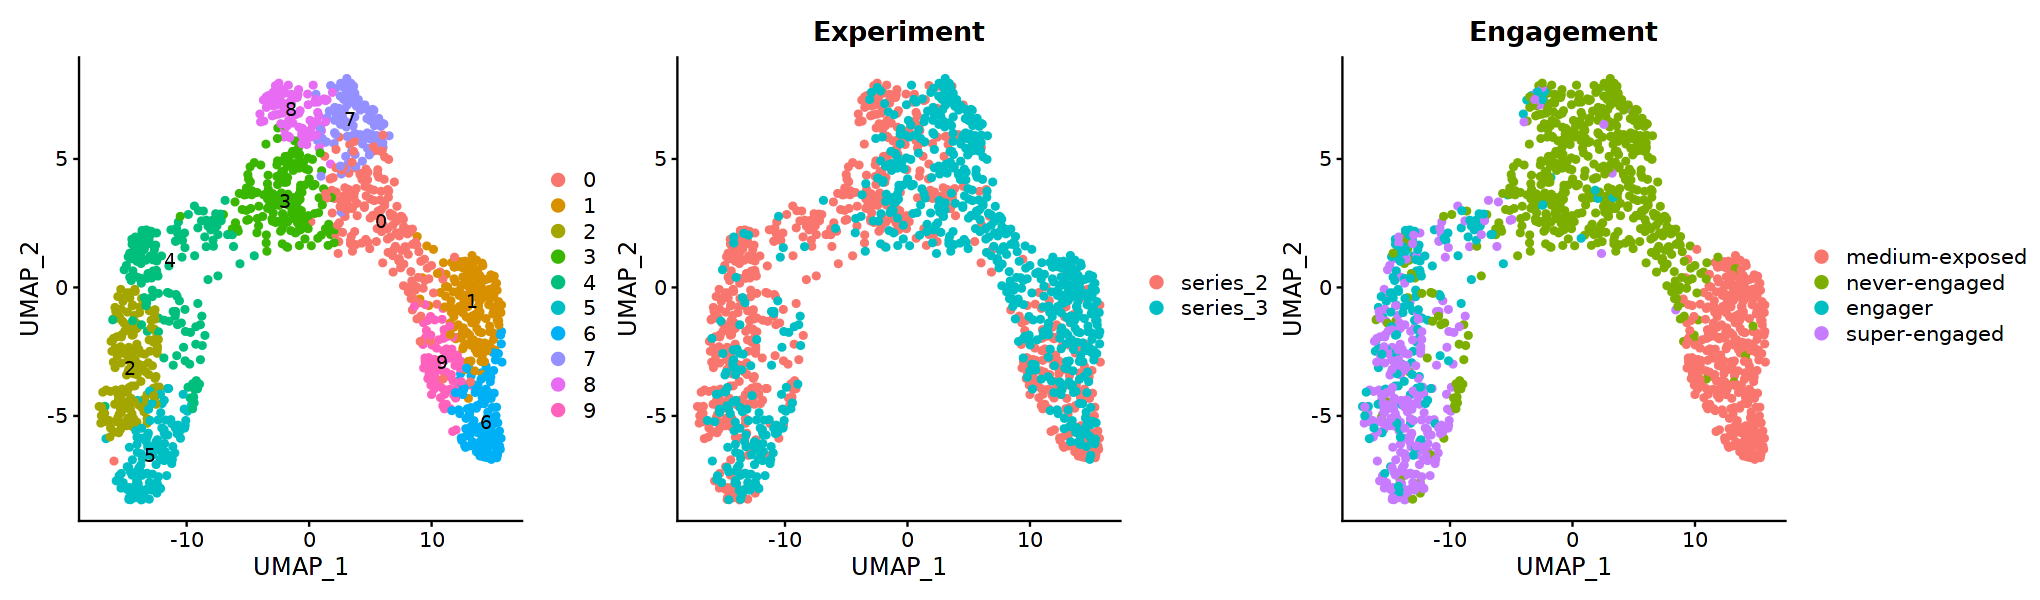

In [21]:
# There is a clear batch effect between experiments. Correct for it with MNN
cd4_2_mnn = RunFastMNN(object.list = SplitObject(cd4_2, split.by = "Experiment"), features = 2000, verbose=F)

# UMAP embedding & Clustering
cd4_2_mnn = RunUMAP(cd4_2_mnn, dims=1:15, min.dist=0.3, spread=2.5, reduction="mnn", verbose=F) %>% FindNeighbors(dims=1:15, reduction="mnn", k.param=40, verbose=F) %>% FindClusters(resolution=2, verbose=F)
cd4_2_mnn$Engagement = factor(cd4_2_mnn$Engagement, levels=c("medium-exposed", "never-engaged", "engager", "super-engaged"))

# Plot
options(repr.plot.width=17, repr.plot.height=5)
DimPlot(cd4_2_mnn, label=T, pt.size=1.5) + DimPlot(cd4_2_mnn, label=F, pt.size=1.5, group.by="Experiment") +
DimPlot(cd4_2_mnn, label=F, pt.size=1.5, group.by="Engagement", shuffle=T)

It is apparent that there is still remaining batch-specific clusters.</br>Since we are mostly interested in shared behavioral mode of actions, we will only keep cluster of cells that are shared between two experiments.

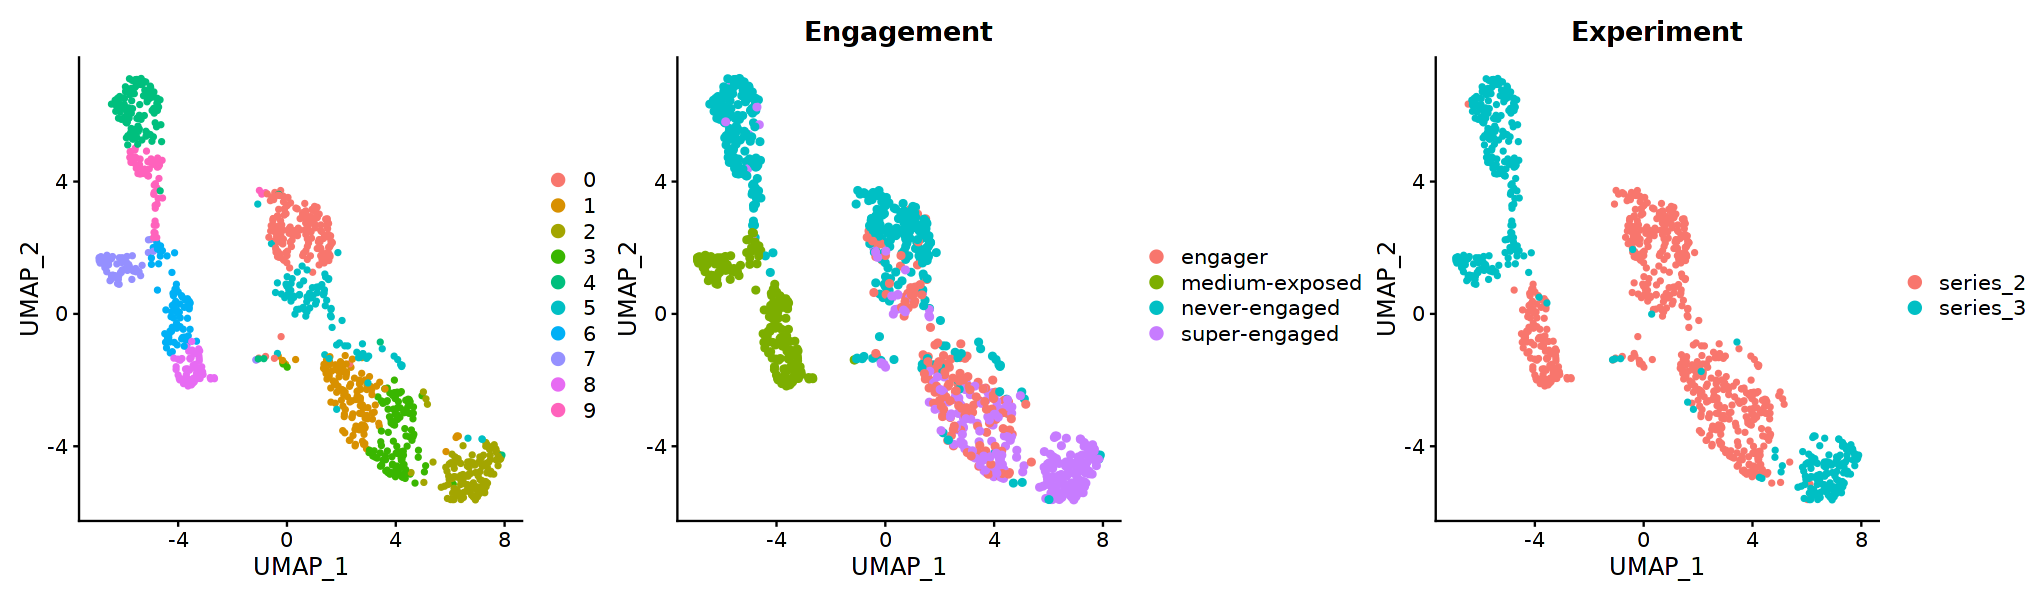

In [22]:
cd4_2_mnn_2 = subset(cd4_2_mnn, idents=c(0, 1), invert=T)
counts = GetAssayData(cd4_2_mnn_2, slot = "counts")
cd4_2_2 = CreateSeuratObject(counts = counts, project = "cd4", min.cells = 0, min.features = 0)
cd4_2_2$Engagement = factor(cd4_2_mnn_2$Engagement, levels = c("medium-exposed", "never-engaged", "nonengager", "engager", "super-engaged"))
cd4_2_2$Engagement = gsub("nonengager", "never-engaged", cd4_2_2$Engagement)
cd4_2_2$Organoid = cd4_2_mnn_2$Organoid
cd4_2_2$Experiment = cd4_2_mnn_2$Experiment
cd4_2_2$Plate = cd4_2_mnn_2$Plate

# Normalized & Scale & PCA dimentionality reduction
cd4_2_2 = NormalizeData(cd4_2_2, verbose=F) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData(features=rownames(cd8), verbose=F) %>% RunPCA(verbose=F)

# UMAP embedding & Clusting
cd4_2_2 = RunUMAP(cd4_2_2, dims=1:12, min.dist=0.2, verbose=F) %>% FindNeighbors(dims=1:12, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)

# Plot
options(repr.plot.width=17, repr.plot.height=5)
DimPlot(cd4_2_2) + DimPlot(cd4_2_2, group.by="Engagement", pt.size=1.5, shuffle=T) + DimPlot(cd4_2_2, group.by="Experiment")

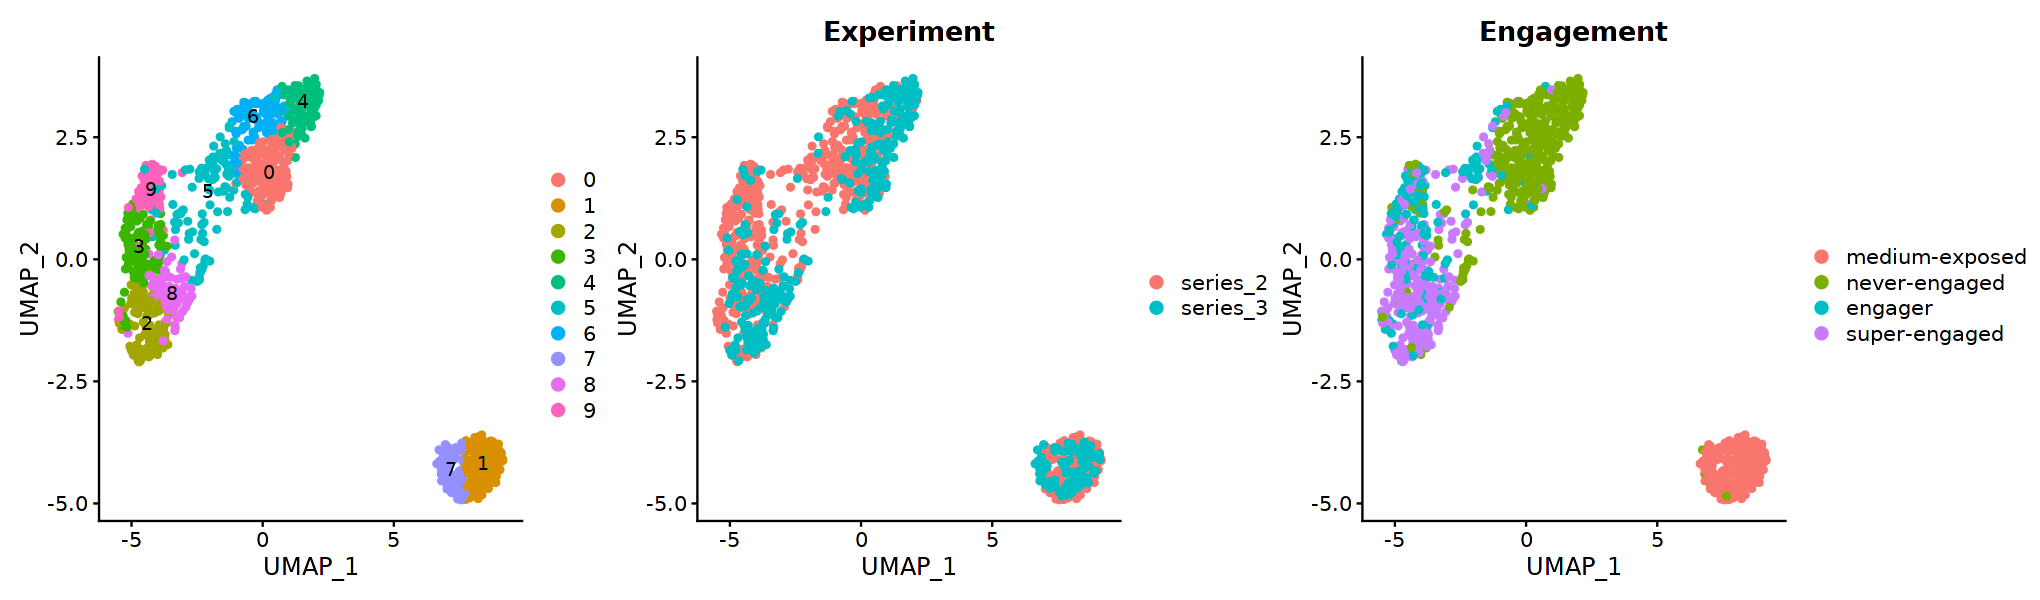

In [23]:
# Correct for the experimental batch effect
# There is a clear batch effect between experiments. Correct for it with MNN
cd4_2_2_mnn = RunFastMNN(object.list = SplitObject(cd4_2_2, split.by="Experiment"), features=3000, verbose=F)

# UMAP embedding & Clusting
cd4_2_2_mnn = RunUMAP(cd4_2_2_mnn, dims=1:15, min.dist=0.2, spread=0.7, reduction="mnn", verbose=F) %>% FindNeighbors(dims=1:15, reduction="mnn", k.param=40, verbose=F) %>% FindClusters(resolution=2.5, verbose=F)
cd4_2_2_mnn$Engagement = factor(cd4_2_2_mnn$Engagement, levels = c("medium-exposed", "never-engaged", "engager", "super-engaged"))

# Plot
options(repr.plot.width=17, repr.plot.height=5)
DimPlot(cd4_2_2_mnn, label=T, pt.size=1.5) +
DimPlot(cd4_2_2_mnn, label=F, pt.size=1.5, group.by="Experiment") +
DimPlot(cd4_2_2_mnn, label=F, pt.size=1.5, group.by="Engagement", shuffle=T)

#### 2.2.3.3 Save Seurat Object for Downstream Analysis
From the above results, we have successfully corrected the batch effect and save the <code>cd4_2_2_mnn</code> object for downstream analysis.

In [24]:
saveRDS(cd4_2_2_mnn, "CD4_IL17RBNeg_MNN_Seurat.rds")

</br>

#### 2.2.4 Analyze CD4+/IL17RB+ T Cells
#### 2.2.4.1 Generate Seurat Object and Embed Cells
Just like before, we generate a new Seurat object of only CD4+ IL17RB+ T cells and analyze them using the <code><a>Guided Clustering Tutorial</a></code> workflow.

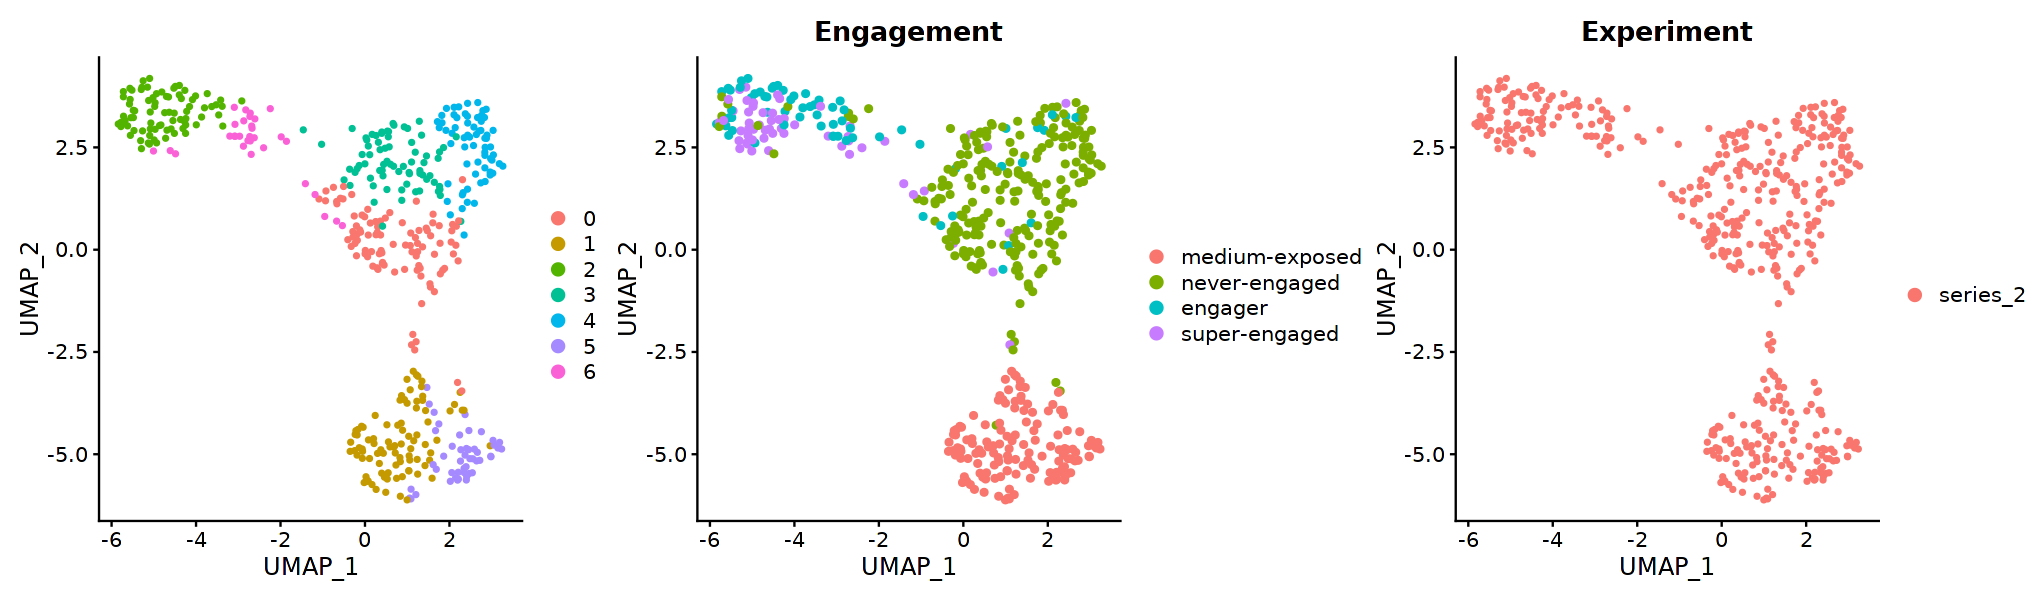

In [25]:
cd4_counts = GetAssayData(cd4_temp_1, slot="counts")
cd4_3 = CreateSeuratObject(counts = cd4_counts, project = "cd4", min.cells = 0, min.features = 0)
cd4_3$Engagement = factor(cd4_temp_1$Engagement, levels = c("medium-exposed", "never-engaged", "nonengager", "engager", "super-engaged"))
cd4_3$Engagement = gsub("nonengager", "never-engaged", cd4_3$Engagement)
cd4_3$Organoid = cd4_temp_1$Organoid
cd4_3$Experiment = cd4_temp_1$Experiment
cd4_3$Plate = cd4_temp_1$Plate

# Normalized & Scale & PCA dimentionality reduction
cd4_3 = NormalizeData(cd4_3, verbose=F) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData(features=rownames(cd8), verbose=F) %>% RunPCA(verbose=F)

# UMAP embedding & Clusting
cd4_3 = RunUMAP(cd4_3, dims=1:12, min.dist=0.2, verbose=F) %>% FindNeighbors(dims=1:12, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)
cd4_3$Engagement = factor(cd4_3$Engagement, levels = c("medium-exposed", "never-engaged", "engager", "super-engaged"))

# Plot
options(repr.plot.width=17, repr.plot.height=5)
DimPlot(cd4_3) + DimPlot(cd4_3, group.by="Engagement", pt.size=1.5, shuffle=T) + DimPlot(cd4_3, group.by="Experiment")

#### 2.2.4.2 Save Seurat Object for Downstream Analysis
As this CD4+ T cells are only appeared in one experiment series, there is no need to batch correct, and we will save the <code>cd4_3</code> object for downstream analysis.

In [26]:
saveRDS(cd4_3, "CD4_IL17RBPos_MNN_Seurat.rds")

</br>

## 3. Generate a Seurat Object of all T Cells
### 3.1 Generate the Object and Subset to Have Only Verified Cells
As the final step in this workflow, we will generate a seurat object using only the verified cells (from previous analysis steps) and embed them in one single <code>UMAP</code>.</br>
To this aim, we again read-in the original Seurat object and subset it to have only verified cells.

In [27]:
teg_orig = readRDS("1_set_N2_3_13T_N0_EXTENDED_MNN_umap.rds")
cd8 = readRDS("CD8_MNN_Seurat.rds")
cd4_1 = readRDS("CD4_IL17RBNeg_MNN_Seurat.rds")
cd4_2 = readRDS("CD4_IL17RBPos_MNN_Seurat.rds")
cells = data.frame(Cells = c(colnames(cd8), colnames(cd4_1), colnames(cd4_2)),
                   Subset = c(rep("CD8", ncol(cd8)), rep("CD4 IL17-", ncol(cd4_1)), rep("CD4 IL17+", ncol(cd4_2))))
teg_orig = subset(teg_orig, cells = cells$Cells)
teg_orig$Subset = cells$Subset

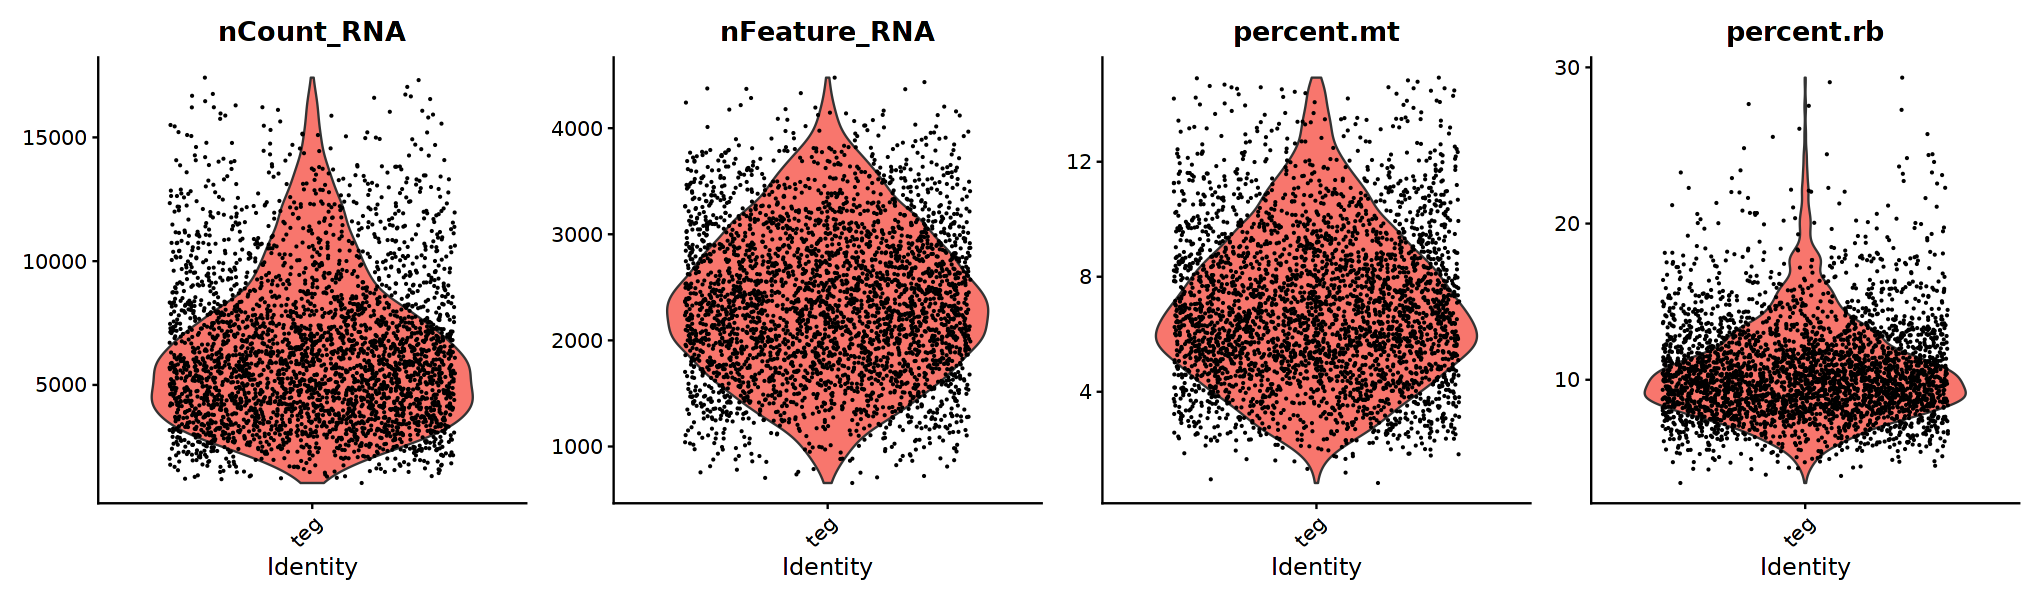

In [28]:
# Generate a new Seurat object
teg_counts = GetAssayData(teg_orig, slot = "counts")
teg = CreateSeuratObject(counts = teg_counts, project = "teg", min.cells = 0, min.features = 0)
teg$Engagement = teg_orig$engagement
teg$Engagement = gsub("nonengager", "never-engaged", teg$Engagement)
teg$Organoid = teg_orig$Organoid
teg$Experiment = teg_orig$experiment
teg$Plate = teg_orig$plate
teg$Subset = teg_orig$Subset
teg[["percent.mt"]] = PercentageFeatureSet(teg, pattern = "MT-")
teg[["percent.rb"]] = PercentageFeatureSet(teg, pattern = "^RP[LS]")
VlnPlot(teg, features = c("nCount_RNA", "nFeature_RNA", "percent.mt", "percent.rb"), ncol = 4)

### 3.2 Normalize & Scale & Reduce dimentionality of the data

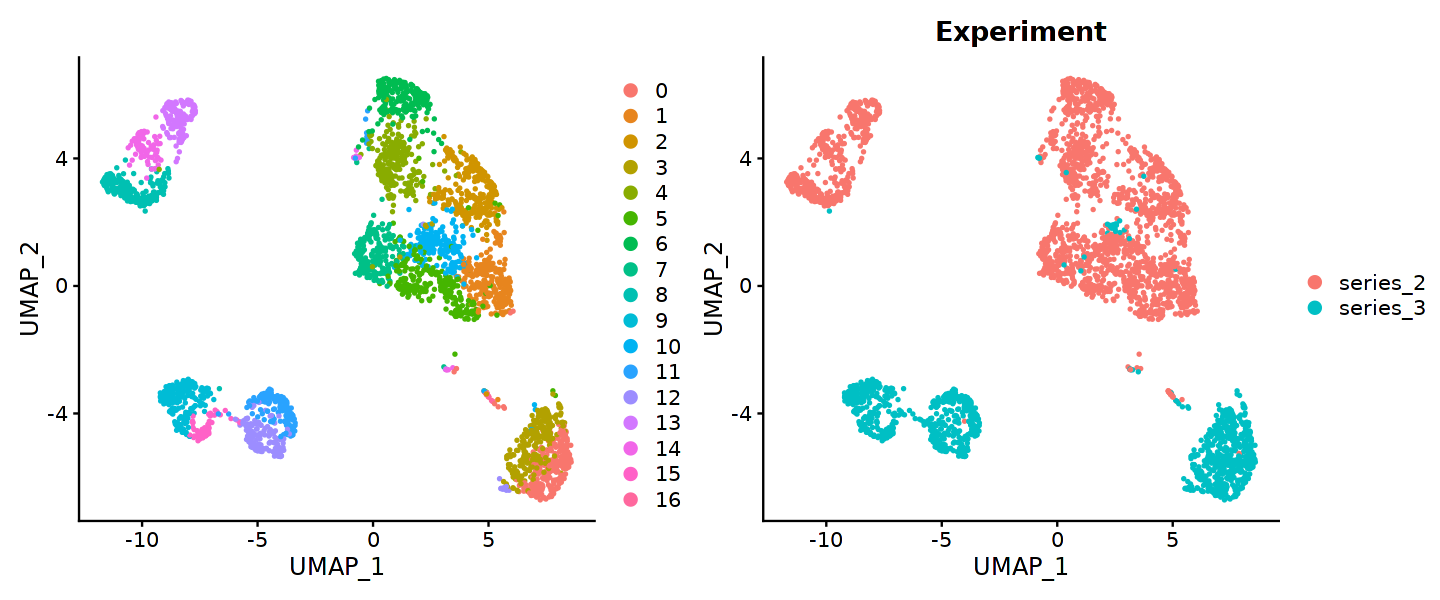

In [29]:
# Remove mito and rb genes
mt.genes = rownames(teg)[grep("^MT-", rownames(teg))]
rb.genes = rownames(teg)[grep("^RP[LS]", rownames(teg))]
genes = c(mt.genes, rb.genes)
genes.keep = setdiff(rownames(teg), genes)
teg = subset(teg, features = genes.keep)
rm(genes, genes.keep, mt.genes, rb.genes)

# Normalized & Scale & PCA dimentionality reduction
teg = NormalizeData(teg, verbose=F) %>% FindVariableFeatures(nfeatures = 3000) %>% ScaleData(features=rownames(cd8), verbose=F) %>% RunPCA(verbose=F)

# UMAP embedding & Clusting
teg = RunUMAP(teg, dims=1:15, min.dist=0.2, verbose=F) %>% FindNeighbors(dims=1:15, k.param=30, verbose=F) %>% FindClusters(resolution=2, verbose=F)

# Plot
options(repr.plot.width=12, repr.plot.height=5)
DimPlot(teg) + DimPlot(teg, group.by = "Experiment")

### 3.3 Batch Correction
Based on the results of the previous section, there is a clear experimental batch effect that needs to be corrected.</br>

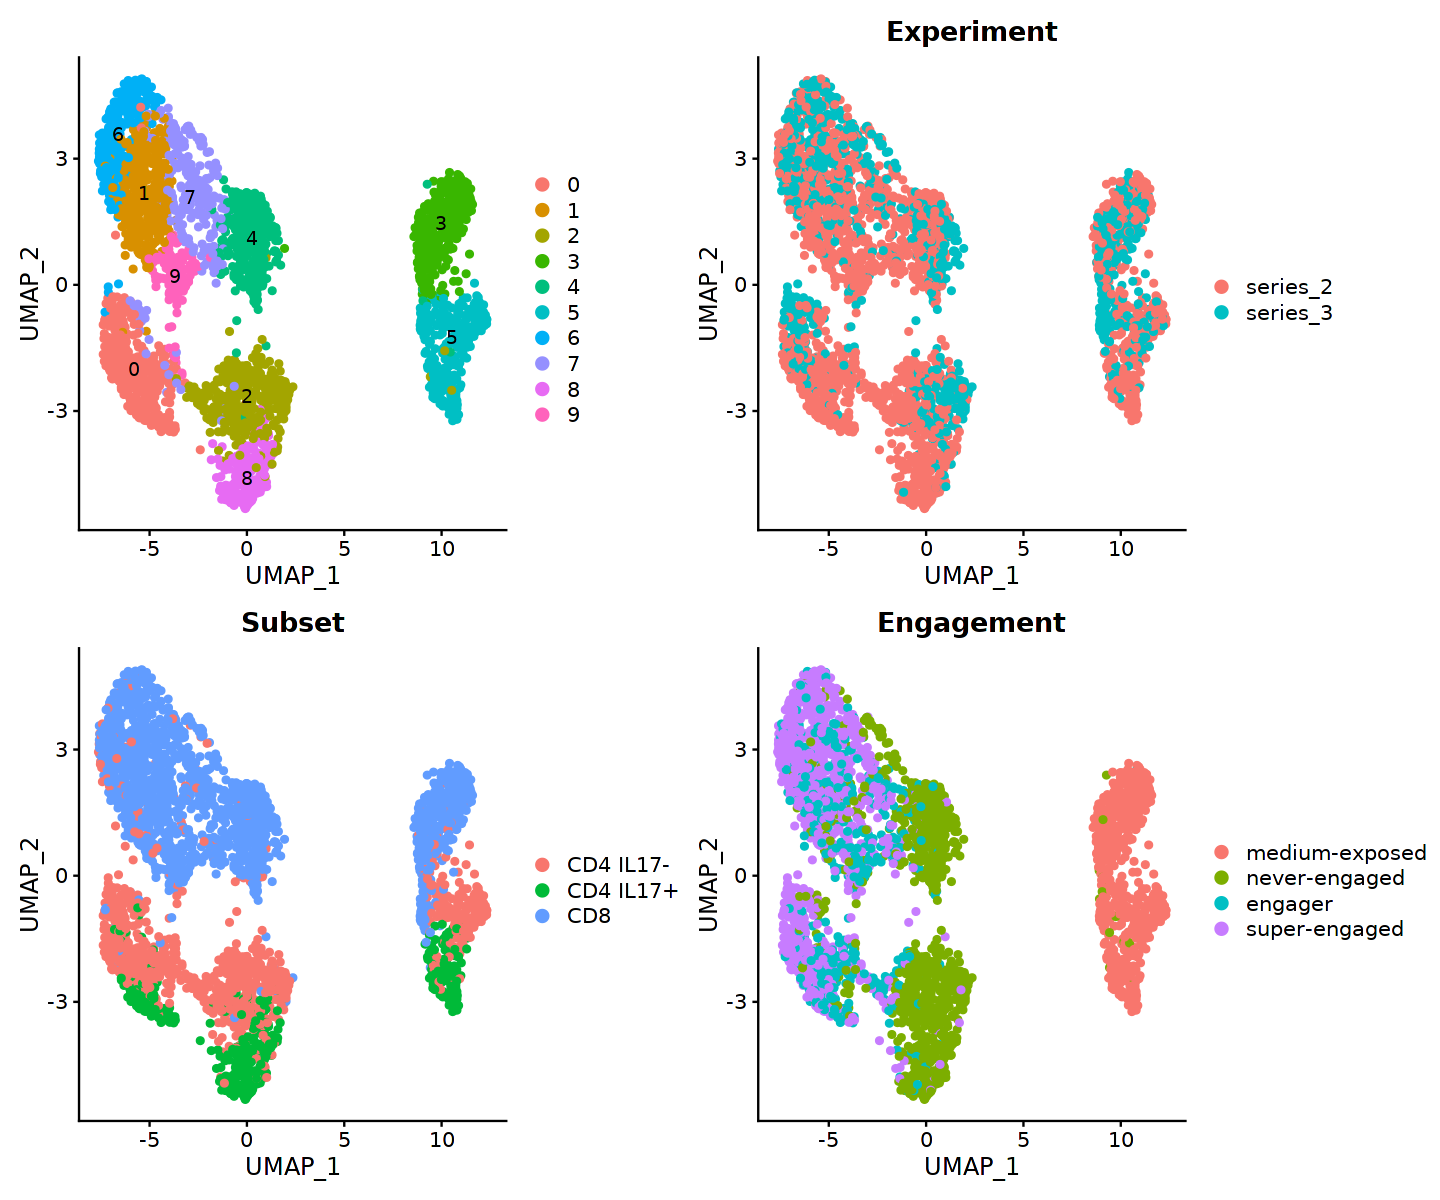

In [30]:
teg_mnn = RunFastMNN(object.list = SplitObject(teg, split.by="Experiment"), features=3000, verbose=F)

# UMAP embedding & Clusting
teg_mnn = RunUMAP(teg_mnn, dims=1:15, min.dist=0.3, spread=1, reduction="mnn", verbose=F) %>% FindNeighbors(dims=1:15, reduction="mnn", k.param=40, verbose=F) %>% FindClusters(resolution=1.5, verbose=F)
teg_mnn$Subset = factor(teg_mnn$Subset, levels = c("CD4 IL17-", "CD4 IL17+", "CD8"))
teg_mnn$Engagement = factor(teg_mnn$Engagement, levels = c("medium-exposed", "never-engaged", "engager", "super-engaged"))

# Plot
options(repr.plot.width=12, repr.plot.height=10)
DimPlot(teg_mnn, label=T, pt.size=1.5) + DimPlot(teg_mnn, label=F, pt.size=1.5, group.by="Experiment", shuffle=T) +
DimPlot(teg_mnn, label=F, pt.size=1.5, group.by="Subset", shuffle=T) +
DimPlot(teg_mnn, label=F, pt.size=1.5, group.by="Engagement", shuffle=T)

### 3.4 Save Seurat Object
From the above results, we have successfully corrected the batch effect and save the <code>teg_mnn</code> object.

In [31]:
saveRDS(teg_mnn, "All_TEGs_MNN_Seurat.rds")

In [32]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 10 (buster)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] SeuratWrappers_0.3.0 ggplot2_3.3.3        dplyr_1.0.5         
[4] SeuratObject_4.0.0   Seurat_3.9.9.9038   

loaded via a namespace (and not attached):
  [1] uuid_0.1-4                  plyr_1.8.6                 
  [3] igraph_1.2.6                rep